In [ ]:
!pip install rfpimp
!pip install eli5
!pip install cxplain
!git clone https://github.com/bondyra/pyBreakDown
%cd ./pyBreakDown
!python3 setup.py install
!pip install shap
!pip install lime

!pip install pdpbox
!pip install --upgrade scikit-learn
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
!pip install numpy --upgrade

In [ ]:
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, r2_score
from scipy.special import comb
import sklearn as skl
import matplotlib.pyplot as plt
import matplotlib as matplt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgbm

from pdpbox import pdp, get_dataset, info_plots
from alepython import ale_plot

import rfpimp as rfpimp
import eli5 as eli5
import cxplain as cxplain
import shap as shap
import lime as lime

from pyBreakDown.explainer import Explainer
from pyBreakDown.explanation import Explanation

import os, sys
import warnings
from contextlib import contextmanager
from tqdm import tqdm
from timeit import default_timer as timer
from google.colab import drive
from copy import deepcopy
%load_ext autoreload
%autoreload 2
%pylab inline
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
sns.set_palette("tab10")
drive.mount('/content/drive')

In [ ]:
path_to_datasets = "/content/drive/MyDrive/Diary_experiments/diabetes/"
random_state = 99
np.random.seed(random_state)

In [ ]:
data = pd.read_csv(path_to_datasets + "diabetes.csv")

for ind in range(len(data.dtypes.values)):
  c_type = data.dtypes.values[ind]
  if c_type == np.int64:
    data.iloc[:, ind] = data.iloc[:, ind].astype('int32')
  elif c_type == np.float64:
    data.iloc[:, ind] = data.iloc[:, ind].astype('float32')

# Implementation of functions used further   

In [ ]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


def sec_to_date_string(time_last):
    h = time_last // (60 * 60)
    m = (time_last % (60 * 60)) // 60
    s = (time_last % (60 * 60)) % 60
    return '{0}h {1}min {2}sec'.format(h, m, s)


# For filter methods 

def f1_metric(model, X_valid, y_valid, sample_weights=None):
    return f1_score(y_valid, model.predict(X_valid))


def all_feature_interaction(clf, X, n_samples=1000):
    """Finds feature interaction value for each column in X.

    The FI value is the amount of the variance explained by 
    the interaction (difference between observed and no-interaction Partial Dependence)

    Parameters
    ----------
    X : pandas frame
    clf : must have predict and decision function

    Returns
    -------
    H2_all : numpy array
        All feature interaction in the same column order as given in X
    """
    preds = clf.predict(X).reshape(-1, 1)
    pd_one_m = pd_one(clf, X, n_samples)
    pd_all_exc_one_m = pd_all_exc_one(clf, X, n_samples)

    norm_term = np.sum(np.square(preds))

    H2_all = np.sum(np.square(preds - pd_one_m - pd_all_exc_one_m), axis=0) / norm_term

    return H2_all.ravel()


def pd_all_exc_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(all_variables_except_j == values in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """

    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        uni = X.iloc[:, col_i].unique()
        if uni.shape[0] > n_samples:
            uni = np.random.choice(uni, n_samples, replace=False)
        nunique.append(uni)

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            preds = []
            for uniq in nunique[i]:
                mrow = row
                mrow[i] = uniq
                preds.append(clf.predict(mrow.reshape(1, -1)))
            answer[ind_r, i] = np.array(preds).mean()
        ind_r += 1
    return answer


def pd_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(j_variable == value in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """
    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        nunique.append(X.iloc[:, col_i].unique())

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            samples_not_i = np.empty((n_samples, num_cols - 1))
            for j in range(num_cols - 1):
                add_ind = 0
                if (j > i):
                    add_ind = 1

                samples_not_i[:, j] = np.random.choice(nunique[j + add_ind], size=n_samples)

            data = np.hstack((samples_not_i[:, :j], np.full((n_samples, 1), row[i]), samples_not_i[:, j:]))
            answer[ind_r, i] = clf.predict(data).mean()
        ind_r += 1
    return answer


# For experiments 

def rfpimp_dt_im(clf=None, X_valid=None, y_valid=None, metric=None, **kwargs):

    if clf is None or \
        X_valid is None or \
        y_valid is None or \
        metric is None:
        raise TypeError("One of the arguments is not set")

    im = rfpimp.importances(clf, X_valid, y_valid, metric=metric)
    for i in range(99):
        im += rfpimp.importances(clf, X_valid, y_valid, metric=metric)
    im /= 100
    im.columns = ['rfpimp (permutation)']
    return im


def eli5_dt_im(clf=None, X_train=None, **kwargs):

    if clf is None or \
        X_train is None:
        raise TypeError("One of the arguments is not set")
    
    p = None
    try:
        p = eli5.explain_weights_lightgbm(clf, importance_type='gain')
        im = p.feature_importances.importances
        fi = pd.DataFrame(index=X_train.columns, columns=['eli5 (gain)'])
        for el in im:
            fi.loc[el.feature] = el.weight
        return fi
    except:
        pass
    
    try:
        def replace_to_name(x):
            return X_train.columns[int(x[1:])]

        p = eli5.explain_weights_df(clf)
        p = p[p['feature'] != '<BIAS>']
        p['feature'] = p.feature.apply(replace_to_name)
        del p['target']
        p.columns = ['index', 'eli5']
        p.set_index('index', inplace=True)
        return p
    except:
        pass
    
    if p is None:
        raise ValueError('Wrong type of clf')
    


def pyBreakDown_dt_im(clf=None, X_train=None, X_valid=None, **kwargs):

    if clf is None or \
        X_train is None or \
        X_valid is None:
        raise TypeError("One of the arguments is not set")

    exp = Explainer(clf=clf, data=X_train, colnames=X_train.columns)
    fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
    for i in range(X_valid.shape[0]):
        explanation = exp.explain(X_valid.values[i, :], direction='up')
        for attr in explanation._attributes:
            fi.iloc[i][attr.name] = attr.contribution
    fi = pd.DataFrame(data=fi.mean(axis=0), columns=['pyBreakDown (up)'])
    return fi


def shap_dt_im(clf=None, X_train=None, X_valid=None, **kwargs):

    if clf is None or \
        X_train is None or \
        X_valid is None:
        raise TypeError("One of the arguments is not set")

    explainer = None
    im = None
    try:
        explainer = shap.explainers.Tree(clf, X_train, random_state=random_state)
        im = np.mean(np.array(explainer.shap_values(X_valid)), axis=0)
    except:
        pass
    
    try:
        explainer = shap.KernelExplainer(clf.predict_proba, X_train, random_state=random_state)
        im = np.mean(np.array(explainer.shap_values(X_valid, nsamples=100)[0]), axis=0)
    except:
        pass
    
    if explainer is None:
        raise ValueError('Wrong type of clf')
    
    fi = pd.DataFrame(data=pd.Series(data=im, index=X_train.columns), columns=['shap'])
    return fi


def lime_dt_im(clf=None, X_train=None, X_valid=None, **kwargs):

    if clf is None or \
        X_train is None or \
        X_valid is None:
        raise TypeError("One of the arguments is not set")

    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, random_state=random_state)
    fi = pd.DataFrame(index=np.arange(X_valid.shape[0]), columns=X_train.columns)
    for i in range(X_valid.shape[0]):
        explanation = explainer.explain_instance(X_valid.values[i, :], clf.predict_proba).as_list()
        ind_c = 0
        for attr in explanation:
            fi.iloc[i][X_valid.columns[ind_c]] = attr[1]
            ind_c += 1
    fi = pd.DataFrame(data=fi.mean(axis=0), columns=['lime'])
    return fi


def get_feature_importances(clf, X_train, X_valid, y_valid, metric):
    all_fi = pd.DataFrame(index=X_train.columns)

    # add rfpimp
    # average by 100 runs
    im = rfpimp_dt_im(clf, X_valid, y_valid, metric)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add eli5
    im = eli5_dt_im(clf, X_train)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add pyBreakDown
    im = pyBreakDown_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add shap 
    im = shap_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    # add lime
    im = lime_dt_im(clf, X_train, X_valid)
    all_fi = pd.concat([all_fi, im], axis=1)

    return all_fi


def mean_sampled_score(clf, norm_all_fi, X_train, y_train, X_test, y_test,
                       num_iter=100, sample_size=[0.3, 0.5, 0.7], metric=f1_score):
    '''Computes mean metric value by sampling features according to their 
    normolized importance and evaluating on train/test sets. Sampled size 
    is equal to percent * (amount of all columns). 
    
    Parameters
    ----------
    clf: must have fit, predict
        Must have warm_start=False
    norm_all_fi: pandas DataFrame
        Rows: columns of dataset, columns: names of feature importance methods
        Value in cell = importance of accroding (column, method)
    num_iter: int
        The amount of times to repeat sample columns
    sample_size: list
        Percents of columns to sample 
    metric: function like "f1_metric(y_true, y_predicted)"
        Return score 

    Returns
    -------
    info: list
        Contains elements like [feature_importances, test_score]
    '''
    results = pd.DataFrame(columns=list(norm_all_fi.columns) + ['sample_size'])
    setup = {
        'num_iter': num_iter,
        'sample_size': sample_size
    }
    inds = list(norm_all_fi.index)
    count_cols = len(X_test.columns)

    ind = 0
    for sample_s in setup['sample_size']:
        count_samples = int(np.ceil(count_cols * sample_s))
        real_count_it = setup['num_iter']
        
        # check if num_iter too big
        # if (comb(count_cols, count_samples) < real_count_it):
        #     real_count_it = int(comb(count_cols, count_samples))

        for _ in range(real_count_it):
            scores = []
            for alg in norm_all_fi.columns:
                cur_cols = np.random.choice(inds, size=count_samples, replace=False, p=list(norm_all_fi[alg].values))
                
                temp_clf = clf
                temp_clf.fit(X_train[cur_cols], y_train)
                scores.append(metric(y_test, temp_clf.predict(X_test[cur_cols])))
            results.loc[ind] = scores + [sample_s]
            ind += 1
    return results


def plot_setup_1(results, params):
    len_s = len(params['sample_size'])
    fig, axs = plt.subplots(len_s, 1, figsize=(10, len_s * 5))

    for ind in range(len_s):
        s_size = params['sample_size'][ind]
        axs[ind].boxplot(results[results['sample_size'] == s_size].values[:, :-1],
                        labels=results.columns[:-1], showfliers=False)

        axs[ind].set_title("Test f1 score depending on feature importance method on the selected features ({0}%)".format(int(s_size * 100)))
        axs[ind].set_xlabel("Feature importance method")
        axs[ind].set_ylabel("F1 score")
        axs[ind].grid(True)

    fig.tight_layout()
    fig.savefig(path_to_datasets + "f1_feature_size.pdf", bbox_inches='tight')
    return axs


def RFE(clf, importance, metric, X_train, y_train, X_valid, y_valid, 
        X_test, y_test, final_size=0.5):
    '''On each iteration eliminates the least important variable

    Parameters
    ----------
    clf: must have fit, predict
        Must have warm_start=False
    importance: pandas DataFrame
        1 column: name of method, n_cols raws: names of predictors
    metric: function like "f1_metric(model, X_valid, y_valid, sample_weights)"

    Returns
    -------
    info: list
        Contains elements like [feature_importances, test_score]
    '''
    params = {
        'clf': clf,
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'X_test': X_test,
        'y_test': y_test,
        'metric': metric
    }
    info = []
    end_size = int(np.ceil(X_train.shape[1] * final_size))
    cur_cols = X_train.columns

    while len(cur_cols) != end_size - 1:
        params['X_train'] = X_train.loc[:, cur_cols]
        params['X_valid'] = X_valid.loc[:, cur_cols]
        params['X_test'] = X_test.loc[:, cur_cols]
        
        clf.fit(params['X_train'], y_train)
        params['clf'] = clf

        im = importance(**params)
        score = metric(clf, params['X_test'], y_test)
        info.append([im, score])

        selected_cols = im[im.columns[0]].abs().sort_values(ascending=False).iloc[:-1].index
        cur_cols = selected_cols
    
    return info


def setup_2(clf, im_methods, metric, X_train, y_train, X_valid, y_valid, 
            X_test, y_test, final_size=0.5):
    results = []
    for method in im_methods:
        result = RFE(clf, method, metric, X_train, y_train, X_valid, y_valid, 
                      X_test, y_test, final_size)
        results.append(result)
    return results


def plot_setup_2(scores, im_names_methods, fmts):
    fig, ax = plt.subplots(figsize=(10, 5))

    ind = 0
    for m_scores in scores:
        ax.plot(np.arange(len(m_scores)), m_scores, fmts[ind], label=im_names_methods[ind])
        ind += 1

    ax.set_title('Test f1 score depending on the number of columns removed')
    ax.set_ylabel('F1 score')
    ax.set_xlabel('Number of columns removed')
    ax.grid(True)

    ax.legend()
    ax.autoscale_view()
    ax.xaxis.set_major_locator(matplt.ticker.MaxNLocator(integer=True))
    fig.savefig(path_to_datasets + "RFE_f1.pdf", bbox_inches='tight')
    return ax


def original_copy_importances(clf, importance, metric, X_train, y_train, X_valid, y_valid, 
                              X_test, y_test, final_size=0.5):
    '''
    Returns list of [importance_original_variable, importance_copy_variable]
    '''
    params = {
        'clf': clf,
        'X_train': deepcopy(X_train),
        'y_train': deepcopy(y_train),
        'X_valid': deepcopy(X_valid),
        'y_valid': deepcopy(y_valid),
        'X_test': deepcopy(X_test),
        'y_test': deepcopy(y_test),
        'metric': deepcopy(metric)
    }
    info = []
    end_size = int(np.ceil(params['X_train'].shape[1] * final_size))
    cur_cols = params['X_train'].columns
    
    clf.fit(params['X_train'], y_train)
    params['clf'] = clf

    im = importance(**params)

    im = im[im.columns[0]].abs().sort_values(ascending=False)
    copy_col_name = im.index[0]
    params['X_train'][copy_col_name + '_copy'] = params['X_train'][copy_col_name]
    params['X_valid'][copy_col_name + '_copy'] = params['X_valid'][copy_col_name]
    params['X_test'][copy_col_name + '_copy'] = params['X_test'][copy_col_name]

    cur_cols = params['X_train'].columns
    while len(cur_cols) != end_size - 1:
        params['X_train'] = params['X_train'].loc[:, cur_cols]
        params['X_valid'] = params['X_valid'].loc[:, cur_cols]
        params['X_test'] = params['X_test'].loc[:, cur_cols]
        
        clf.fit(params['X_train'], y_train)
        params['clf'] = clf

        im = importance(**params)
        im = im[im.columns[0]].abs().sort_values(ascending=False)
        im /= im.sum()
        
        index_im = list(im.index)
        ind_r = len(im.index) - 1

        while (index_im[ind_r] == copy_col_name or \
              index_im[ind_r] == copy_col_name + '_copy') \
              and ind_r != -1:
              ind_r -= 1
        
        info.append([im.loc[copy_col_name], im.loc[copy_col_name + '_copy']])
        if ind_r == -1:
            return info
        else:
            index_im.remove(index_im[ind_r])

        cur_cols = index_im

    return info


def setup_3(clf, im_methods, metric, X_train, y_train, X_valid, y_valid,
            X_test, y_test, final_size=0.5):
    results = []
    for method in im_methods:
        result = original_copy_importances(clf, method, metric, X_train, y_train, X_valid, y_valid, 
                                           X_test, y_test, final_size)
        results.append(np.array(result))
    return results


def plot_setup_3(scores, im_names_methods, name=''):
    len_s = len(scores)
    fig, axs = plt.subplots(len_s, 1, figsize=(7, len_s * 4))

    for ind in range(len_s):
        origin = results[ind][:, 0]
        copy = results[ind][:, 1]
        index = np.arange(origin.shape[0])
        width = 0.20

        axs[ind].bar(index - width / 2, origin, width, label='original')
        axs[ind].bar(index + width / 2, copy, width, label='copy')

        axs[ind].set_title("Importances of the variables depending on the columns ({0})".format(im_names_methods[ind]))
        axs[ind].set_xlabel("Number of columns removed")
        axs[ind].set_ylabel("Normalized importance")
        axs[ind].grid(False)
        axs[ind].grid(True, axis='y')
        axs[ind].legend()

    fig.tight_layout()
    fig.savefig(path_to_datasets + "original_copy_" + name + ".pdf", bbox_inches='tight')
    return axs

#Goal
To check how filter, wrapper, embedded works:
* **to learn about the filter methods** from [here](https://christophm.github.io/interpretable-ml-book/agnostic.html)
* **make an experiment** on how well feature importance is estimated:  
For every feature importance methods:
  1. Calculate importance
  2. Delete/Mask $n$ the least/most informative variables
  3. Calculate score (f1, log-odds) 
  4. Repeat until stopping criteria (min_feature, f1-threshold)

> _NOTE:_  
> - if method doesn't recognize correlated feature we will see sharp rise on a specific iteration






Data was taken from [Diabete Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

In [ ]:
data.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
508,2,84,50,23,76,30.400000,0.968,21,0
712,10,129,62,36,0,41.200001,0.441,38,1
187,1,128,98,41,58,32.000000,1.321,33,1
314,7,109,80,31,0,35.900002,1.127,43,1
502,6,0,68,41,0,39.000000,0.727,41,1
281,10,129,76,28,122,35.900002,0.280,39,0
168,4,110,66,0,0,31.900000,0.471,29,0
674,8,91,82,0,0,35.599998,0.587,68,0
9,8,125,96,0,0,0.000000,0.232,54,1
140,3,128,78,0,0,21.100000,0.268,55,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int32  
 1   Glucose                   768 non-null    int32  
 2   BloodPressure             768 non-null    int32  
 3   SkinThickness             768 non-null    int32  
 4   Insulin                   768 non-null    int32  
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int32  
 8   Outcome                   768 non-null    int32  
dtypes: float32(2), int32(7)
memory usage: 27.1 KB


In [ ]:
X, y = data.drop(columns=['Outcome']), data['Outcome']
print('Есть дисбаланс классов. Доля "1": ', y.mean())

Есть дисбаланс классов. Доля "1":  0.3489583333333333


In [ ]:
# Features that are important on the training set but not on the held-out set might cause the model to overfit.
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2,random_state=random_state)

In [ ]:
clf = lgbm.LGBMClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.5925925925925926


# Filter methods

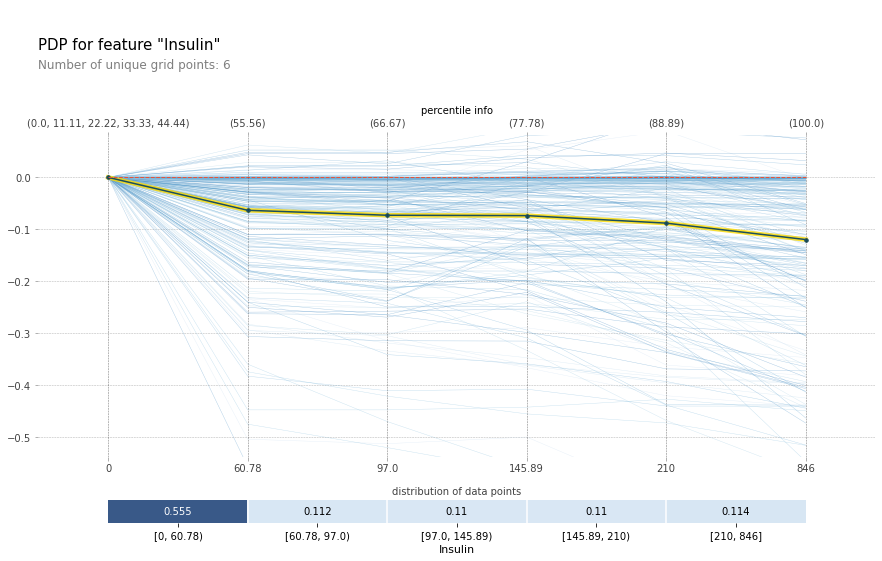

In [ ]:
with suppress_stdout():
  pdp_Insulin = pdp.pdp_isolate(
    model=clf, dataset=X_train, model_features=X_train.columns, feature='Insulin'
  )
  fig, axes = pdp.pdp_plot(
    pdp_Insulin, 'Insulin', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
  ) 

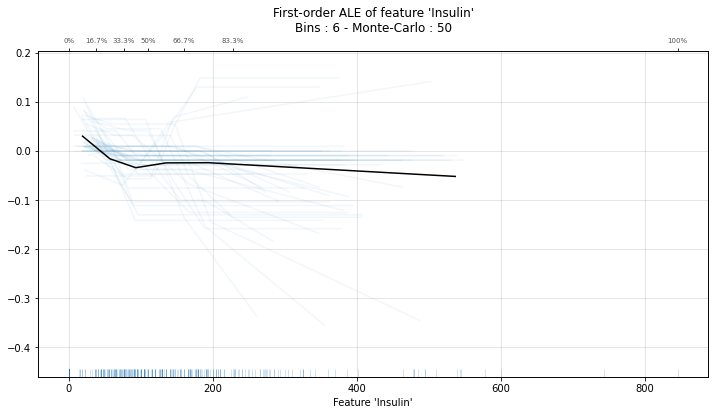

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6))
ale_plot(clf, X_train, 'Insulin', monte_carlo=True)
plt.show()

Pretty the same as PDP + ICE, beside region 33.3% - 50%

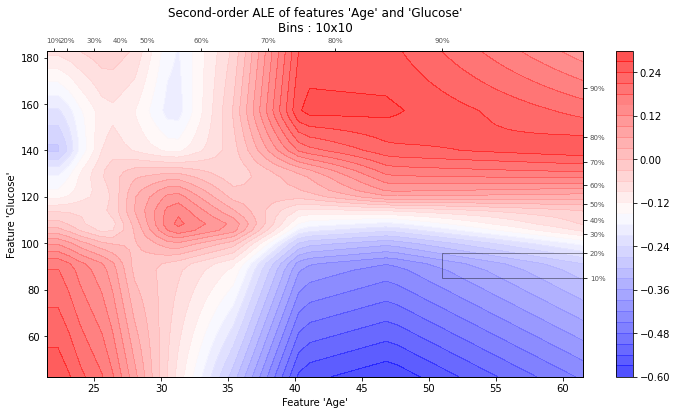

In [ ]:
  ale_plot(clf, X_train, ['Age', 'Glucose'], monte_carlo=True)
plt.show()

You can see that in the right area there is a white line, that shows that in a certain age range glucose have determining factor

In [ ]:
start = timer()
f_ints = all_feature_interaction(clf, X_train, n_samples=10000)
end = timer()

time_last = int(end - start)
print(sec_to_date_string(time_last))

0h 4min 18sec


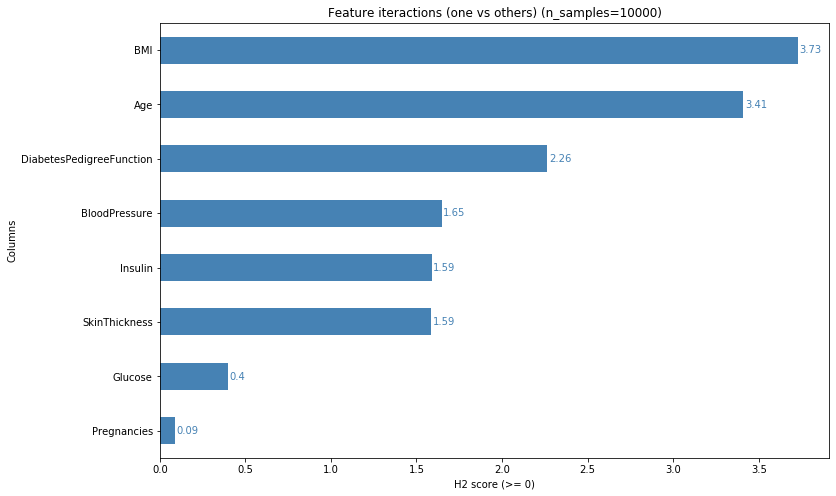

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

data = {'columns': X_train.columns, 
              'feature_interaction': f_ints}
data = pd.DataFrame(data,  index=data['columns'])
data.sort_values(by = "feature_interaction").plot(kind = "barh", color = "steelblue", legend = False, grid = True, ax = ax) 
plt.grid(False)
ax.set_title('Feature iteractions (one vs others) (n_samples=10000)')
ax.set_ylabel('Columns')
ax.set_xlabel('H2 score (>= 0)')

for i, v in enumerate(sorted(data.feature_interaction)):
    plt.text(v+0.01, i, str(round(v, 2)), color='steelblue', va="center")

$H_{j}^{2}=\sum_{i=1}^{n}\left[\hat{f}\left(x^{(i)}\right)-P D_{j}\left(x_{j}^{(i)}\right)-P D_{-j}\left(x_{-j}^{(i)}\right)\right]^{2} / \sum_{i=1}^{n} \hat{f}^{2}\left(x^{(i)}\right)$

# Working with libraries
Let's see *in what form* you can find out the feature importance (instance-wise/dataset-wise)

**rfpimp** (dataset)

In [ ]:
#permutation importance
rfpimp.importances(clf, X_valid, y_valid, metric=f1_metric)

,Importance
Feature,
BMI,0.182140
Glucose,0.137931
Age,0.056722
SkinThickness,0.043678
DiabetesPedigreeFunction,-0.000766
Insulin,-0.015145
BloodPressure,-0.015413
Pregnancies,-0.022989


**eli5** (dataset)

In [ ]:
p = eli5.explain_weights_lightgbm(clf, importance_type='gain')
p.feature_importances.importances

[FeatureWeight(feature='Glucose', weight=0.34983589422721695, std=None, value=None),
 FeatureWeight(feature='BMI', weight=0.17103643977815364, std=None, value=None),
 FeatureWeight(feature='DiabetesPedigreeFunction', weight=0.13398387643946763, std=None, value=None),
 FeatureWeight(feature='Age', weight=0.11703521024776035, std=None, value=None),
 FeatureWeight(feature='BloodPressure', weight=0.06469495764760744, std=None, value=None),
 FeatureWeight(feature='Pregnancies', weight=0.061797171950049, std=None, value=None),
 FeatureWeight(feature='Insulin', weight=0.058763539922075496, std=None, value=None),
 FeatureWeight(feature='SkinThickness', weight=0.04285290978766951, std=None, value=None)]

**pyBreakDown** (instance)

In [ ]:
exp = Explainer(clf=clf, data=X_train, colnames=X_train.columns)
explanation = exp.explain(X_valid.values[0, :], direction='up')
explanation._attributes

deque([AttrInfo(name='Intercept', value=1, contribution=0.0, cumulative=0.0),
       AttrInfo(name='DiabetesPedigreeFunction', value=0.15299999713897705, contribution=-0.10183299389002032, cumulative=-0.10183299389002032),
       AttrInfo(name='Insulin', value=110.0, contribution=-0.06720977596741345, cumulative=-0.16904276985743377),
       AttrInfo(name='Glucose', value=136.0, contribution=-0.04276985743380857, cumulative=-0.21181262729124234),
       AttrInfo(name='Pregnancies', value=15.0, contribution=-0.07128309572301425, cumulative=-0.28309572301425656),
       AttrInfo(name='BloodPressure', value=70.0, contribution=-0.0264765784114053, cumulative=-0.30957230142566183),
       AttrInfo(name='BMI', value=37.099998474121094, contribution=-0.03258655804480652, cumulative=-0.34215885947046837),
       AttrInfo(name='Age', value=43.0, contribution=-0.016293279022403257, cumulative=-0.3584521384928716),
       AttrInfo(name='SkinThickness', value=32.0, contribution=0.0, cumulative=-0.

**shap** (dataset)

In [ ]:
explainer = shap.explainers.Tree(clf, X_train, random_state=random_state)
explainer.shap_values(X_valid), explainer.shap_values(X_train).shape 

(array([[-0.28806503, -0.34239263,  0.41067515, ..., -3.07705744,
          0.5679885 , -0.51598094],
        [-0.30440004, -0.3350343 , -0.28410546, ...,  1.26665718,
          0.56458097, -0.59825327],
        [-0.47650196, -1.34027969,  0.66167681, ..., -1.40089857,
          0.99447541,  0.00520211],
        ...,
        [-0.11059918,  2.61588811,  0.1408319 , ...,  1.09892547,
          0.62684149,  0.13290573],
        [ 0.20859442, -0.52099368,  0.08421468, ..., -1.70558947,
          0.84187768,  0.45104852],
        [-0.14857633,  1.60972855,  0.02390436, ...,  0.68108839,
         -0.60105533, -0.38741581]]), (537, 8))

**lime** (instance)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, random_state=random_state)
exp = explainer.explain_instance(X_valid.values[0, :], clf.predict_proba)
exp.as_list()

[('5 <= 27.30', -0.2518720854750491),
 ('117.00 < 1 <= 140.00', 0.09585440399118611),
 ('6 > 0.64', 0.08109044233575842),
 ('7 <= 24.00', -0.07273557172543223),
 ('38.00 < 4 <= 130.00', -0.036823106320470034),
 ('2 <= 64.00', 0.03315196501600474),
 ('0.00 < 3 <= 23.00', -0.02613083039983704),
 ('0 <= 1.00', -0.00654594087898715)]

**cxplain** (dataset)  

See example [here](https://github.com/d909b/cxplain/blob/master/examples/boston_housing.ipynb)

#### Let's save all the importances things in the one table

In [ ]:
all_fi = get_feature_importances(clf, X_train, X_valid, y_valid, f1_metric)
all_fi.reset_index(inplace=True)
all_fi.to_csv(path_to_datasets + 'all_fi.csv', sep='\t', encoding='utf-8', index=False)
all_fi.set_index('index', inplace=True)
all_fi

,rfpimp (permutation),eli5 (gain),pyBreakDown (up),shap,lime
index,,,,,
Pregnancies,0.003533,0.0679259,-0.005266,0.065743,-0.010329
Glucose,0.220216,0.35181,0.046330,0.106348,0.032806
BloodPressure,0.008010,0.0543541,-0.010647,-0.036307,0.016641
SkinThickness,0.023585,0.0419407,0.001954,-0.047088,0.011410
Insulin,0.006759,0.0558564,-0.015846,0.000081,-0.004175
BMI,0.080515,0.203102,0.002302,0.076896,-0.006063
DiabetesPedigreeFunction,0.005757,0.130346,-0.009041,-0.016016,-0.001520
Age,0.038616,0.0946643,0.005746,0.025990,-0.000033


#### Now we need only scores (positive and which are summed to 1)

In [ ]:
norm_all_fi = (all_fi.abs() / all_fi.abs().sum(axis=0))
norm_all_fi.reset_index(inplace=True)
norm_all_fi.to_csv(path_to_datasets + 'norm_all_fi.csv', sep='\t', encoding='utf-8', index=False)
norm_all_fi.set_index('index', inplace=True)
norm_all_fi.sort_values('shap', ascending=False)

,rfpimp (permutation),eli5 (gain),pyBreakDown (up),shap,lime
index,,,,,
Glucose,0.569046,0.35181,0.476986,0.283996,0.395363
BMI,0.208053,0.203102,0.0236959,0.205347,0.0730748
Pregnancies,0.00912985,0.0679259,0.0542107,0.175563,0.124481
SkinThickness,0.060945,0.0419407,0.0201159,0.125746,0.137504
BloodPressure,0.0206982,0.0543541,0.109615,0.0969542,0.200548
Age,0.0997855,0.0946643,0.0591544,0.0694055,0.000396751
DiabetesPedigreeFunction,0.0148757,0.130346,0.0930788,0.042771,0.0183227
Insulin,0.017466,0.0558564,0.163144,0.000217171,0.0503097


In [ ]:
# norm_all_fi = pd.read_csv(path_to_datasets + 'norm_all_fi.csv', sep='\t', encoding='utf-8')
# norm_all_fi.set_index('index', inplace=True)

# all_fi = pd.read_csv(path_to_datasets + 'all_fi.csv', sep='\t', encoding='utf-8')
# all_fi.set_index('index', inplace=True)

# Experiments

## Setup 1: Sampled feature importance
1. Calculate overall feature importance
2. Sample n percent features according to fi scores
3. Retrain base model, check metric

In [ ]:
params = {
    'num_iter': 1000,
    'sample_size': [0.3, 0.5, 0.7]
}

results = mean_sampled_score(clf, norm_all_fi, X_train, y_train, X_test, y_test, 
                             num_iter=params['num_iter'], sample_size=params['sample_size'], metric=f1_score)

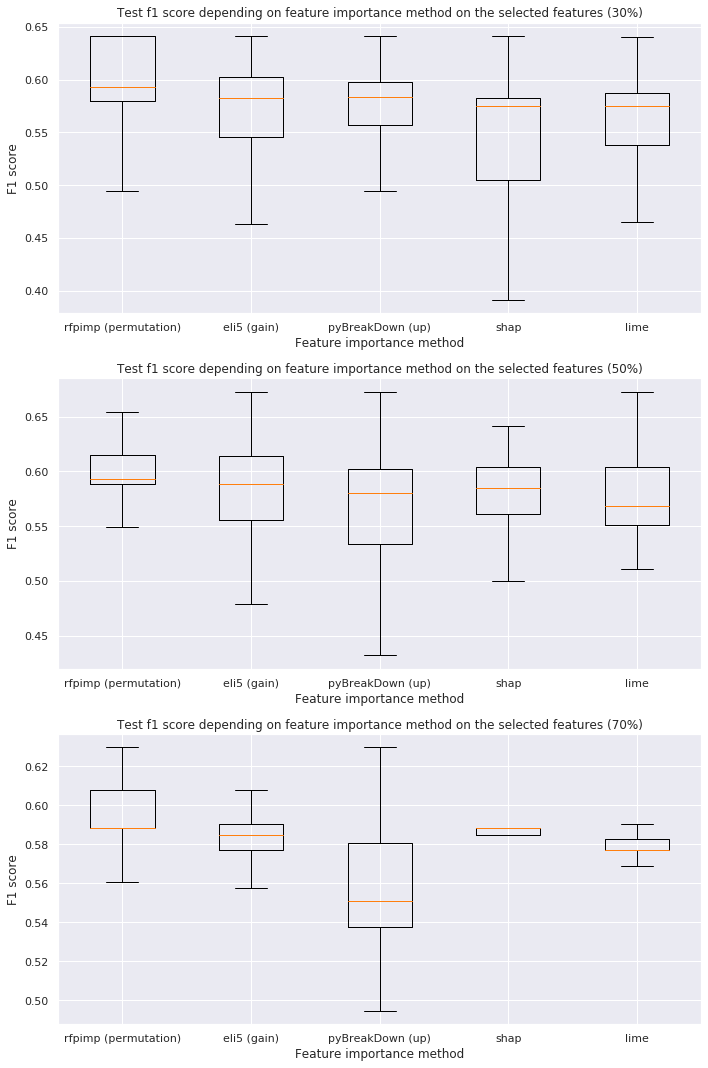

In [ ]:
plot_setup_1(results, params)
plt.show()

**rfpimp** wins (median value) in all sample size configs    
**lime** wins (lower std) in all sample size configs

## Setup 2: RFE

In [ ]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im]
results = setup_2(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                  X_test, y_test, final_size=0.1)
scores = [[y[1] for y in z] for z in results]

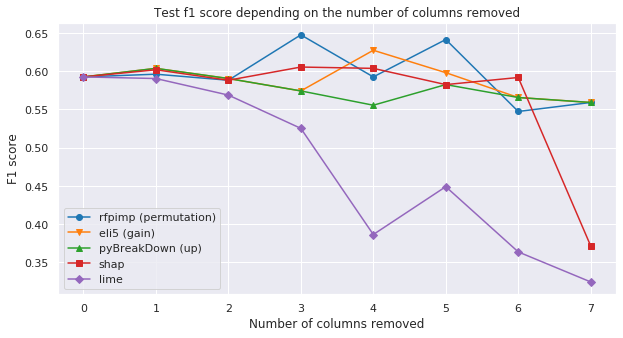

In [ ]:
im_names_methods = ['rfpimp (permutation)', 'eli5 (gain)', 'pyBreakDown (up)', 'shap', 'lime']
fmts = ['-o', '-v', '-^', '-s', '-D']
plot_setup_2(scores, im_names_methods, fmts)
plt.show()

Even with a *single* column, you can build a classifier that does not lag far behind in the metric.  
**rfpimp** well determines whether the predictor can be useful in *general*.

## Setup 3: Feature importance of copy
1. Take the most important variable on whole train dataset
2. Add copy of it to data
3. Remove the least important variable, besides variables at 1. and 2.
4. Check importances (sums to 1) of the remanings variables
5. Remember fi of variables at 1. and 2.


In [ ]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im]
results = setup_3(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                  X_test, y_test, final_size=0.1)

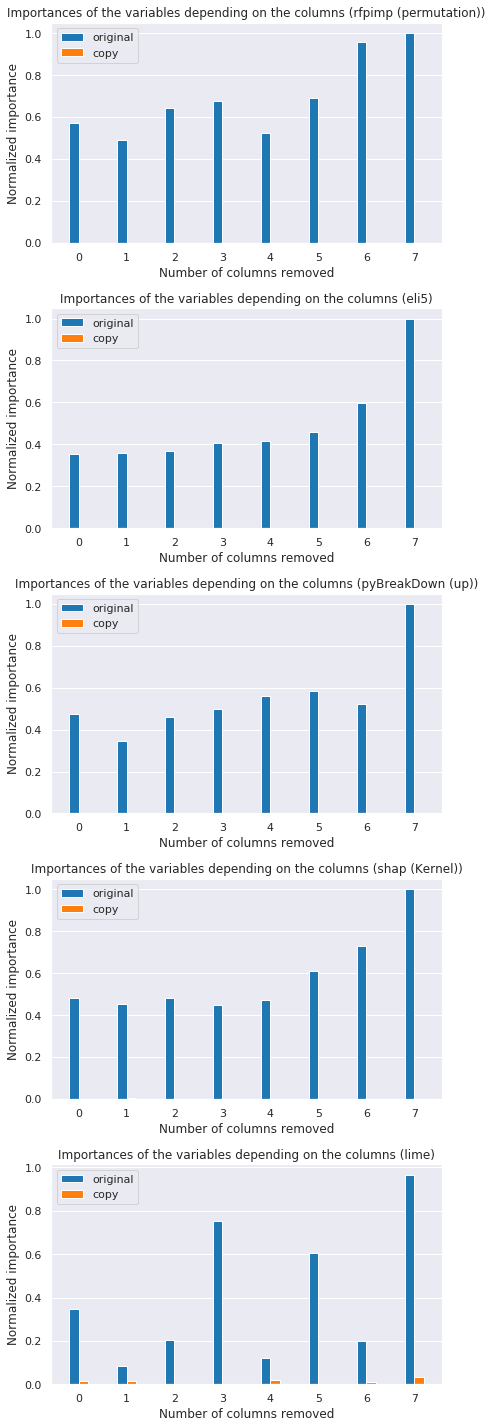

In [ ]:
im_names_methods = ['rfpimp (permutation)', 'eli5', 'pyBreakDown (up)', 'shap (Kernel)', 'lime']
plot_setup_3(results, im_names_methods, 'lgbm')
plt.show()

**Lgbm** gives all the importance to the *one* copy.  
Let's try with **svm**.

In [ ]:
# Features that are important on the training set but not on the held-out set might cause the model to overfit.
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2,random_state=random_state)

In [ ]:
scaler = skl.preprocessing.StandardScaler()
X_train.iloc[:, :] = scaler.fit_transform(X_train.iloc[:, :])
X_valid.iloc[:, :] = scaler.transform(X_valid.iloc[:, :])
X_test.iloc[:, :] = scaler.transform(X_test.iloc[:, :])

In [ ]:
clf = skl.svm.SVC(kernel='linear', probability=True, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.6808510638297872


In [ ]:
im_methods = [rfpimp_dt_im, eli5_dt_im, pyBreakDown_dt_im, shap_dt_im, lime_dt_im]
begin = timer()
results = setup_3(clf, im_methods, f1_metric, X_train, y_train, X_valid, y_valid,
                  X_test, y_test, final_size=0.1)
end = timer()
print(sec_to_date_string(int(end - begin)))

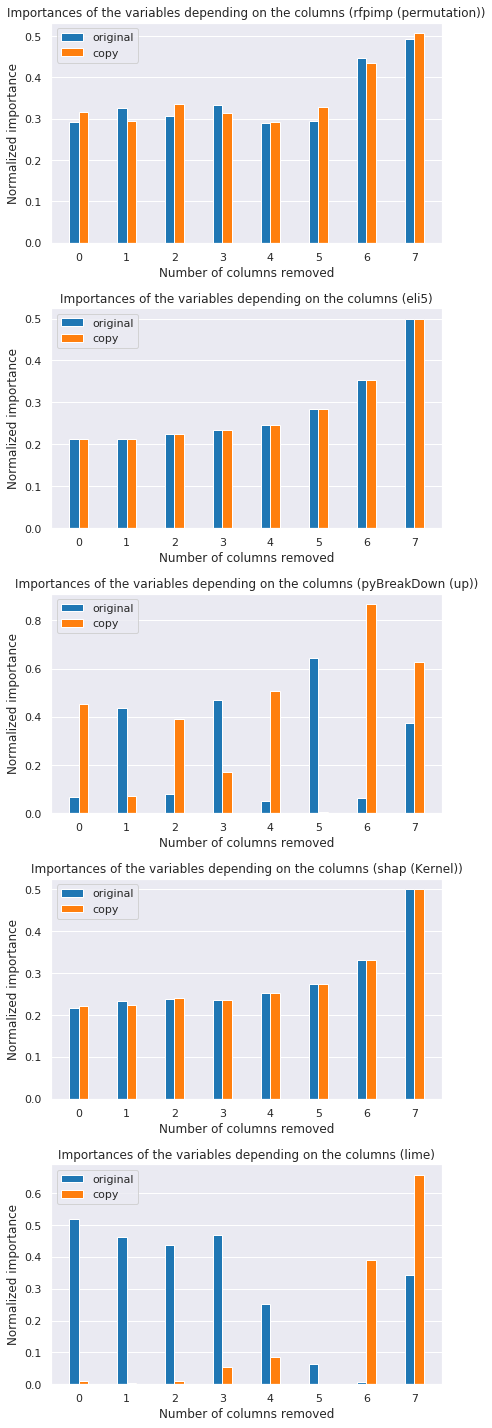

In [ ]:
im_names_methods = ['rfpimp (permutation)', 'eli5', 'pyBreakDown (up)', 'shap (Kernel)', 'lime']
plot_setup_3(results, im_names_methods, 'svm')
plt.show()

**eli5**, **rfpimp**, **shap** have an *symmetric* distribution.  
**pyBreakDown**, **lime** on the contrary have an *asymmetric* distribution.
